In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from IPython.extensions.autoreload import append_obj
from networkx import fast_gnp_random_graph
from sklearn.preprocessing import StandardScaler
from datetime import date, datetime
import yfinance as yf


In [12]:
#Dwonloading historical data for Apple Inc. (AAPL), Microsoft Corp. (MSFT), and Google LLC (GOOGL) to files
tickers = ['AAPL', 'MSFT', 'GOOGL']
for share in tickers:
    data = yf.download(share, start='2010-01-01', end=date.today().strftime('%Y-%m-%d'))
    data.to_csv(f'prices/historical_{share}_data.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
MSFT_data = yf.download('MSFT', start='2000-01-01')

if isinstance(MSFT_data.columns, pd.MultiIndex):
    MSFT_data.columns = MSFT_data.columns.get_level_values(0)
    
### RSI
MSFT_data.ta.rsi(length=14, append=True)

### MACD
MSFT_data.ta.macd(fast=12, slow=26, signal=9, append=True)

### Bollinger Bands
MSFT_data.ta.bbands(length=20,std=2, append=True)

MSFT_data['Target'] = (MSFT_data['Close'].shift(-1) > MSFT_data['Close']).astype(int)

MSFT_data.dropna(inplace=True)

print(MSFT_data.columns)


[*********************100%***********************]  1 of 1 completed


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0_2.0', 'BBM_20_2.0_2.0',
       'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'Target'],
      dtype='object', name='Price')


  observation_date  FEDFUNDS
0       1954-07-01      0.80
1       1954-08-01      1.22
2       1954-09-01      1.07
3       1954-10-01      0.85
4       1954-11-01      0.83


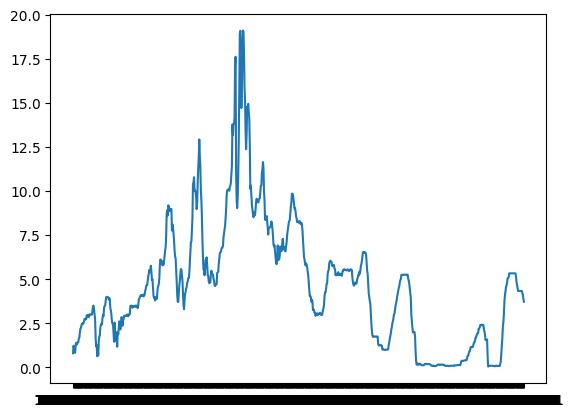

In [3]:
## Loading macro economic data

### Fed Funds Rate (pol: Stopy procentowe)

FEDFUNDS = pd.read_csv('Macroeconomic data/FEDFUNDS.csv')
FEDFUNDS = pd.DataFrame(FEDFUNDS)    
print(FEDFUNDS.head())
plt.plot(FEDFUNDS['observation_date'], FEDFUNDS['FEDFUNDS'])
                               

  observation_date  DGS10
0       1962-01-02   4.06
1       1962-01-03   4.03
2       1962-01-04   3.99
3       1962-01-05   4.02
4       1962-01-08   4.03


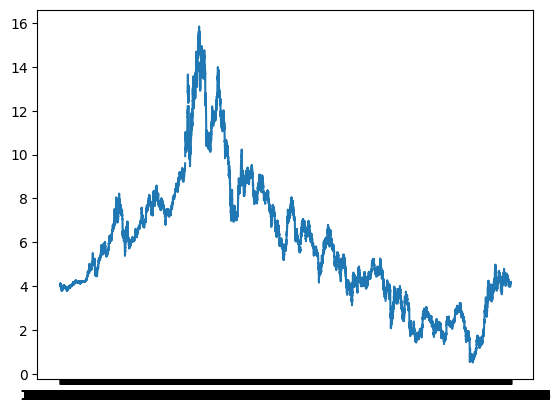

In [8]:
### Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (pol: Rentowność Obligacji 10-letnich)

DGS10 = pd.read_csv('Macroeconomic data/DGS10.csv')
DGS10 = pd.DataFrame(DGS10)
print(DGS10.head())
plt.plot(DGS10['observation_date'], DGS10['DGS10'])

  observation_date    CPI
0       1947-01-01  21.48
1       1947-02-01  21.62
2       1947-03-01  22.00
3       1947-04-01  22.00
4       1947-05-01  21.95
5       1947-06-01  22.08
6       1947-07-01  22.23
7       1947-08-01  22.40
8       1947-09-01  22.84
9       1947-10-01  22.91


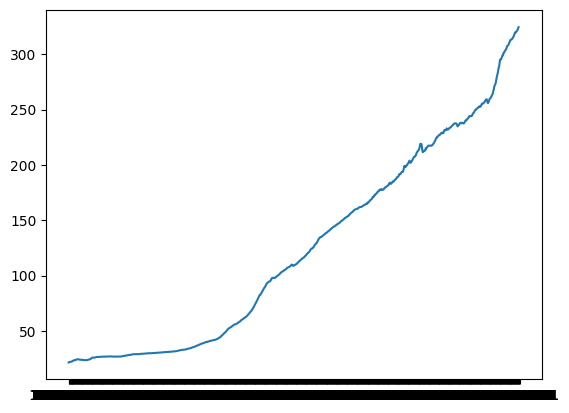

In [4]:
### CPI (pol: Wskaznik inflacji)

CPI = pd.read_csv('Macroeconomic data/CPIAUCSL.csv')
CPI = pd.DataFrame(CPI)
CPI.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
print(CPI.head(10))
plt.plot(CPI['observation_date'], CPI['CPI'])

  observation_date  Dollar_idx
0       2006-01-02    101.4155
1       2006-01-03    100.7558
2       2006-01-04    100.2288
3       2006-01-05    100.2992
4       2006-01-06    100.0241
5       2006-01-09    100.1794
6       2006-01-10    100.1436
7       2006-01-11     99.8710
8       2006-01-12    100.0643
9       2006-01-13     99.9675


Text(0.5, 1.0, 'Dollar Index')

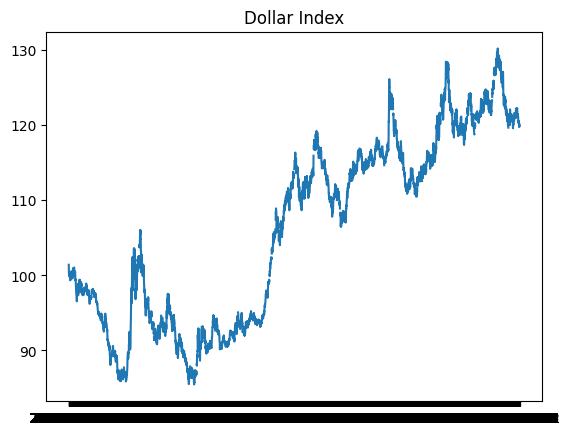

In [5]:
### Dollar index 

Dollar_idx = pd.read_csv('Macroeconomic data/DTWEXBGS.csv')
Dollar_idx = pd.DataFrame(Dollar_idx)
Dollar_idx.rename(columns={'DTWEXBGS': 'Dollar_idx'}, inplace=True)
print(Dollar_idx.head(10))
plt.plot(Dollar_idx['observation_date'], Dollar_idx['Dollar_idx'])
plt.title('Dollar Index')


  observation_date  FEDFUNDS  FEDFUNDS_scaled
0       2007-01-01      5.25         1.948674
1       2007-02-01      5.26         1.953963
2       2007-03-01      5.26         1.953963
3       2007-04-01      5.25         1.948674
4       2007-05-01      5.25         1.948674
  observation_date  DGS10  DGS10_scaled
0       2007-01-01    NaN           NaN
1       2007-01-02   4.68      1.762357
2       2007-01-03   4.67      1.752941
3       2007-01-04   4.62      1.705861
4       2007-01-05   4.65      1.734109
  observation_date      CPI  CPI_scaled
0       2007-01-01  203.437   -1.411603
1       2007-02-01  204.226   -1.387921
2       2007-03-01  205.288   -1.356045
3       2007-04-01  205.904   -1.337556
4       2007-05-01  206.755   -1.312013
  observation_date  Dollar_idx  Dollar_idx_scaled
0       2007-01-01     97.0323          -0.748169
1       2007-01-02         NaN                NaN
2       2007-01-03     97.1281          -0.740555
3       2007-01-04     97.5251          -0.7

Text(0.5, 1.0, 'All Macroeconomic datasets plots')

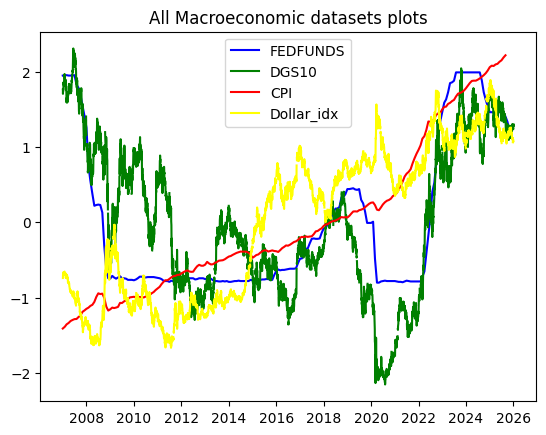

In [9]:
### Setting the same data time for all data

macroeconomic_datasets = [FEDFUNDS, DGS10, CPI, Dollar_idx]
labels = ['FEDFUNDS', 'DGS10', 'CPI', 'Dollar_idx']
plot_colors = ['blue', 'green', 'red', 'yellow', 'black']
scaler = StandardScaler()


for idx, dataset in enumerate(macroeconomic_datasets):
    dataset = dataset[dataset['observation_date'] >= '2007-01-01'].copy()
    dataset['observation_date'] = pd.to_datetime(dataset['observation_date'])
    dataset.sort_values('observation_date', inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    dataset[labels[idx] + "_scaled"] = scaler.fit_transform(dataset[[labels[idx]]])
    print(dataset.head(5))
    plt.plot(dataset['observation_date'], dataset[labels[idx] + '_scaled'], color=plot_colors[idx])
plt.legend(labels)
plt.title('All Macroeconomic datasets plots')
    


In [7]:
## FEAR INDEX


### VIX < 20 -> Relative calm on the stock market
### VIX 20 -30 -> Increased volatility, uncertainty.
### VIX > 30 -> Panic on the stock market 


start_date = datetime(year=2007, month=1, day=1)
end_date = date.today().strftime("%Y-%m-%d")
fear_idx = yf.download(tickers= '^VIX',
                   start=start_date,
                   end=end_date,
                   auto_adjust=True,
                   progress=False,
                   interval="1d")
fear_idx = pd.DataFrame(fear_idx)
fear_idx['VIX_percent'] = fear_idx['Close'].pct_change()
fear_idx.dropna(inplace=True)
fear_idx['Is_Panic'] = (fear_idx['Close'] > 30).astype(int)
fear_idx['Is_Calm'] = (fear_idx['Close'] < 20).astype(int)
fear_idx['Is_Uncertain'] = ((fear_idx['Close'] >= 20) & (fear_idx['Close'] <= 30)).astype(int)

fear_idx.head()

Price,Close,High,Low,Open,Volume,VIX_percent,Is_Panic,Is_Calm,Is_Uncertain
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX,,,,
Date,,,,,,,,,
2007-01-04,11.51,12.42,11.28,12.40,0,-0.044020,0,1,0
2007-01-05,12.14,12.25,11.68,11.84,0,0.054735,0,1,0
2007-01-08,12.00,12.83,11.78,12.48,0,-0.011532,0,1,0
2007-01-09,11.91,12.47,11.69,11.86,0,-0.007500,0,1,0
2007-01-10,11.47,12.50,11.43,12.34,0,-0.036944,0,1,0


In [7]:
## FINANCIAL NEWS SENTIMENT
financial_news = pd.read_csv('Macroeconomic data/Sentences_AllAgree.txt', 
                             sep='@',
                             encoding='latin1', 
                             names=['Sentence', 'Sentiment'])
print(financial_news.head())


                                            Sentence Sentiment
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive


In [10]:
## GEOPOLITICAL FEAR INDEX

geopolitical_fear = pd.read_csv('data_gpr_export.csv')
print(geopolitical_fear.head())

        month  GPR  GPRT  GPRA   GPRH  GPRHT   GPRHA  SHARE_GPR  N10  \
0  12/31/1899  NaN   NaN   NaN  87.93  64.72  110.45        NaN  NaN   
1   1/31/1900  NaN   NaN   NaN  86.57  71.94   96.25        NaN  NaN   
2    3/1/1900  NaN   NaN   NaN  72.14  57.48   84.50        NaN  NaN   
3    4/1/1900  NaN   NaN   NaN  54.42  37.33   65.86        NaN  NaN   
4    5/1/1900  NaN   NaN   NaN  64.41  48.20   74.37        NaN  NaN   

   SHARE_GPRH  ...  GPRHC_TUN  GPRHC_TUR  GPRHC_TWN  GPRHC_UKR  GPRHC_USA  \
0        3.17  ...        0.0       0.04        0.0        0.0       2.72   
1        3.12  ...        0.0       0.13        0.0        0.0       2.73   
2        2.60  ...        0.0       0.18        0.0        0.0       2.15   
3        1.96  ...        0.0       0.07        0.0        0.0       1.78   
4        2.32  ...        0.0       0.08        0.0        0.0       1.97   

   GPRHC_VEN  GPRHC_VNM  GPRHC_ZAF  var_name  \
0       0.05       0.01       1.15     month   
1       